In [15]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import time

import i3d
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9950174867920959433
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2097152
locality {
  bus_id: 1
}
incarnation: 15576292671836102144
physical_device_desc: "device: 0, name: GeForce GTX 1080, pci bus id: 0000:03:00.0, compute capability: 6.1"
]


In [16]:
"""
Build Joint Channel Graph (from i3d.py)
"""
_IMAGE_SIZE = 224
_NUM_CLASSES = 400

_SAMPLE_VIDEO_FRAMES = 25
_SAMPLE_PATHS = {
    'rgb': 'data/v_CricketShot_g04_c01_rgb.npy',
    'flow': 'data/v_CricketShot_g04_c01_flow.npy',
}

_CHECKPOINT_PATHS = {
    'rgb': 'data/checkpoints/rgb_scratch/model.ckpt',
    'flow': 'data/checkpoints/flow_scratch/model.ckpt',
    'rgb_imagenet': 'data/checkpoints/rgb_imagenet/model.ckpt',
    'flow_imagenet': 'data/checkpoints/flow_imagenet/model.ckpt',
}

_LABEL_MAP_PATH = 'data/label_map.txt'



imagenet_pretrained = True # use pretrained model as it had better performance
eval_type = "joint" # build the graph for both streams 
tf.reset_default_graph() # reset graph each time cell is run, prevents duplicate variables

if eval_type not in ['rgb', 'flow', 'joint']:
    raise ValueError('Bad `eval_type`, must be one of rgb, flow, joint')

kinetics_classes = [x.strip() for x in open(_LABEL_MAP_PATH)]

if eval_type in ['rgb', 'joint']:
    # RGB input has 3 channels.
    rgb_input = tf.placeholder(
        tf.float32,
        shape=(1, None, _IMAGE_SIZE, _IMAGE_SIZE, 3))
    with tf.variable_scope('RGB'):
        rgb_model = i3d.InceptionI3d(
            _NUM_CLASSES, spatial_squeeze=True, final_endpoint='Logits')
        rgb_logits, _ = rgb_model(
            rgb_input, is_training=False, dropout_keep_prob=1.0)
    rgb_variable_map = {}
    for variable in tf.global_variables():
        if variable.name.split('/')[0] == 'RGB':
            rgb_variable_map[variable.name.replace(':0', '')] = variable
    rgb_saver = tf.train.Saver(var_list=rgb_variable_map, reshape=True)

if eval_type in ['flow', 'joint']:
    # Flow input has only 2 channels.
    flow_input = tf.placeholder(
        tf.float32,
        shape=(1, None, _IMAGE_SIZE, _IMAGE_SIZE, 2))
    with tf.variable_scope('Flow'):
        flow_model = i3d.InceptionI3d(
            _NUM_CLASSES, spatial_squeeze=True, final_endpoint='Logits')
        flow_logits, _ = flow_model(
            flow_input, is_training=False, dropout_keep_prob=1.0)
    flow_variable_map = {}
    for variable in tf.global_variables():
        if variable.name.split('/')[0] == 'Flow':
            flow_variable_map[variable.name.replace(':0', '')] = variable
    flow_saver = tf.train.Saver(var_list=flow_variable_map, reshape=True)

if eval_type == 'rgb':
    model_logits = rgb_logits
elif eval_type == 'flow':
    model_logits = flow_logits
else:
    model_logits = rgb_logits + flow_logits
model_predictions = tf.nn.softmax(model_logits)

In [17]:
"""
Run sample prediction with RBG only
"""
eval_type = 'rgb' 
print("wiener")
with tf.Session() as sess:
        feed_dict = {}
        if eval_type in ['rgb', 'joint']:
            if imagenet_pretrained:
                rgb_saver.restore(sess, _CHECKPOINT_PATHS['rgb_imagenet'])
            else:
                rgb_saver.restore(sess, _CHECKPOINT_PATHS['rgb'])
            tf.logging.info('RGB checkpoint restored')
            rgb_sample = np.load(_SAMPLE_PATHS['rgb'])
            print("RGB size:", rgb_sample.shape)
            tf.logging.info('RGB data loaded, shape=%s', str(rgb_sample.shape))
            feed_dict[rgb_input] = rgb_sample

        if eval_type in ['flow', 'joint']:
            if imagenet_pretrained:
                flow_saver.restore(sess, _CHECKPOINT_PATHS['flow_imagenet'])
            else:
                flow_saver.restore(sess, _CHECKPOINT_PATHS['flow'])
            tf.logging.info('Flow checkpoint restored')
            flow_sample = np.load(_SAMPLE_PATHS['flow'])
            print("flow size:", flow_sample.shape)
            tf.logging.info('Flow data loaded, shape=%s',
                            str(flow_sample.shape))
            feed_dict[flow_input] = flow_sample

        out_logits, out_predictions = sess.run(
            [model_logits, model_predictions],
            feed_dict=feed_dict)

        out_logits = out_logits[0]
        out_predictions = out_predictions[0]
        sorted_indices = np.argsort(out_predictions)[::-1]

        print('Norm of logits: %f' % np.linalg.norm(out_logits))
        print('\nTop classes and probabilities')
        for index in sorted_indices[:20]:
            print(out_predictions[index], out_logits[
                  index], kinetics_classes[index])

wiener
INFO:tensorflow:Restoring parameters from data/checkpoints/rgb_imagenet/model.ckpt
INFO:tensorflow:RGB checkpoint restored
RGB size: (1, 79, 224, 224, 3)
INFO:tensorflow:RGB data loaded, shape=(1, 79, 224, 224, 3)


InvalidArgumentError: You must feed a value for placeholder tensor 'Placeholder_1' with dtype float and shape [1,?,224,224,2]
	 [[Node: Placeholder_1 = Placeholder[dtype=DT_FLOAT, shape=[1,?,224,224,2], _device="/job:localhost/replica:0/task:0/device:GPU:0"]()]]
	 [[Node: add/_465 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_2666_add", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

Caused by op u'Placeholder_1', defined at:
  File "/usr/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/willsong/kinetics-i3d/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/willsong/kinetics-i3d/local/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/willsong/kinetics-i3d/local/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/home/willsong/kinetics-i3d/local/lib/python2.7/site-packages/tornado/ioloop.py", line 1064, in start
    handler_func(fd_obj, events)
  File "/home/willsong/kinetics-i3d/local/lib/python2.7/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/willsong/kinetics-i3d/local/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/home/willsong/kinetics-i3d/local/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/willsong/kinetics-i3d/local/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/home/willsong/kinetics-i3d/local/lib/python2.7/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/willsong/kinetics-i3d/local/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/willsong/kinetics-i3d/local/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/willsong/kinetics-i3d/local/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/willsong/kinetics-i3d/local/lib/python2.7/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/willsong/kinetics-i3d/local/lib/python2.7/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/willsong/kinetics-i3d/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2714, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/willsong/kinetics-i3d/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2818, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/willsong/kinetics-i3d/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2878, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-16-7c38b7e40205>", line 30, in <module>
    shape=(1, None, _IMAGE_SIZE, _IMAGE_SIZE, 2))
  File "/home/willsong/kinetics-i3d/local/lib/python2.7/site-packages/tensorflow/python/ops/array_ops.py", line 1599, in placeholder
    return gen_array_ops._placeholder(dtype=dtype, shape=shape, name=name)
  File "/home/willsong/kinetics-i3d/local/lib/python2.7/site-packages/tensorflow/python/ops/gen_array_ops.py", line 3091, in _placeholder
    "Placeholder", dtype=dtype, shape=shape, name=name)
  File "/home/willsong/kinetics-i3d/local/lib/python2.7/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/willsong/kinetics-i3d/local/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 2956, in create_op
    op_def=op_def)
  File "/home/willsong/kinetics-i3d/local/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 1470, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): You must feed a value for placeholder tensor 'Placeholder_1' with dtype float and shape [1,?,224,224,2]
	 [[Node: Placeholder_1 = Placeholder[dtype=DT_FLOAT, shape=[1,?,224,224,2], _device="/job:localhost/replica:0/task:0/device:GPU:0"]()]]
	 [[Node: add/_465 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_2666_add", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]


In [6]:
from scipy.ndimage.filters import gaussian_filter1d
def blur_image(X, sigma=1):
    start = time.time()
    X = gaussian_filter1d(X, sigma, axis=1)
    X = gaussian_filter1d(X, sigma, axis=2)
    X = gaussian_filter1d(X, sigma, axis=3)
    print("Blur time", time.time()-start)
    return X

In [7]:
def create_class_visualization(sess, target_y, logits, rgb_input, class_name, **kwargs):
    """
    Generate an image to maximize the score of target_y under a pretrained model.
    
    Inputs:
    - target_y: Integer in the range [0, 1000) giving the index of the class
    - model: A pretrained CNN that will be used to generate the image
    
    Keyword arguments:
    - l2_reg: Strength of L2 regularization on the image
    - learning_rate: How big of a step to take
    - num_iterations: How many iterations to use
    - blur_every: How often to blur the image as an implicit regularizer
    - max_jitter: How much to gjitter the image as an implicit regularizer
    - show_every: How often to show the intermediate result
    """
    print("params", kwargs)
    l2_reg = kwargs.pop('l2_reg', 1e-3)
    learning_rate = kwargs.pop('learning_rate', 25)
    num_iterations = kwargs.pop('num_iterations', 100)
    blur_every = kwargs.pop('blur_every', 4)
    max_jitter = kwargs.pop('max_jitter', 16)
    show_every = kwargs.pop('show_every', 25)
    num_frames = kwargs.pop('num_frames', 25)
    #still_seed = kwargs.pop('still_seed')
    
    # X = np.random.rand(num_frames, 224, 224, 3)
    X = np.random.rand(1, 224, 224, 3) * np.ones((num_frames, 224, 224, 3))
    X = X[None]
    #X = preprocess_image(X)[None]
    
    ########################################################################
    # TODO: Compute the loss and the gradient of the loss with respect to  #
    # the input image, model.image. We compute these outside the loop so   #
    # that we don't have to recompute the gradient graph at each iteration #
    #                                                                      #
    # Note: loss and grad should be TensorFlow Tensors, not numpy arrays!  #
    #                                                                      #
    # The loss is the score for the target label, target_y. You should     #
    # use model.classifier to get the scores, and tf.gradients to compute  #
    # gradients. Don't forget the (subtracted) L2 regularization term!     #
    ########################################################################
    # logits command
    # loss = model.classifier[0, target_y] # scalar loss
    loss = logits[0, target_y] # scalar loss
    
    # model.image is just input data 
    # self.image = tf.placeholder('float',shape=[None,None,None,3],name='input_image')
    # grad = tf.gradients(loss, model.image) # gradient of loss with respect to model.image, same size as model.image
    # grad = tf.squeeze(grad) - l2_reg*2*model.image
    
    grad = tf.gradients(loss, rgb_input)
    grad = tf.squeeze(grad) - l2_reg*2*rgb_input
    ############################################################################
    #                             END OF YOUR CODE                             #
    ############################################################################

    start_time = time.time()
    for t in range(num_iterations):
        
        # Randomly jitter the image a bit; this gives slightly nicer results
        ox, oy = np.random.randint(-max_jitter, max_jitter+1, 2)
        Xi = X.copy()
        X = np.roll(np.roll(X, ox, 1), oy, 2)

        ########################################################################
        # TODO: Use sess to compute the value of the gradient of the score for #
        # class target_y with respect to the pixels of the image, and make a   #
        # gradient step on the image using the learning rate. You should use   #
        # the grad variable you defined above.                                 #
        #                                                                      #
        # Be very careful about the signs of elements in your code.            #
        ########################################################################
        # we want logits for loss, model.classifier are just logits
        # loss = model.classifier[0, target_y] # scalar loss
        loss = logits[0, target_y] # scalar loss

        # model.image is just the data matrix input (a gif in our case)
        # gradient_step = sess.run(grad, feed_dict={model.image:X})
        gradient_step = sess.run(grad, feed_dict={rgb_input:X})
        X += learning_rate * gradient_step
        ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################

        # Undo the jitter
        X = np.roll(np.roll(X, -ox, 1), -oy, 2)

        # As a regularizer, clip and periodically blur
        #X = np.clip(X, -SQUEEZENET_MEAN/SQUEEZENET_STD, (1.0 - SQUEEZENET_MEAN)/SQUEEZENET_STD)
        if t % blur_every == 0:
            X = blur_image(X, sigma=1)
        print("iteration:", t, time.time()-start_time)
        # Periodically show the image
        if t == 0 or (t + 1) % show_every == 0 or t == num_iterations - 1:
            #plt.imshow(deprocess_image(X[0]))
            plt.imshow(X[0][0])
            
            if t == num_iterations-1:
                # save all frames
                print(X[0][0])
                directory = "experiments/{}".format(class_name)
                if not os.path.exists(directory):
                    os.makedirs(directory)
                file_name = directory + "/{}".format(class_name)+ "{}.png"
                print("file_name", file_name)
                filenames = []
                for i in range(0, num_frames):
                    plt.imshow(X[0][i])
                    filename = file_name.format(i)
                    filenames.append(filename)
                    plt.savefig(filename.format(i))
                    # plt.show()
                #create gif
                images = []
                for filename in filenames:
                    images.append(imageio.imread(filename))
                    imageio.mimsave(directory + "/{}".format(class_name) + ".gif", images)
                    
            plt.title('%s\nIteration %d / %d' % (class_name, t + 1, num_iterations))
            plt.gcf().set_size_inches(4, 4)
            plt.axis('off')
            plt.show()
        
    return X

Tensor("RGB/inception_i3d/Mean:0", shape=(1, 400), dtype=float32)
Tensor("Placeholder:0", shape=(1, ?, 224, 224, 3), dtype=float32)
abseiling
INFO:tensorflow:Restoring parameters from data/checkpoints/rgb_imagenet/model.ckpt
params {'num_iterations': 1000, 'learning_rate': 1.5, 'max_jitter': 32, 'blur_every': 3, 'num_frames': 25}
Blur time 0.151307106018
iteration: 0 0.947890996933


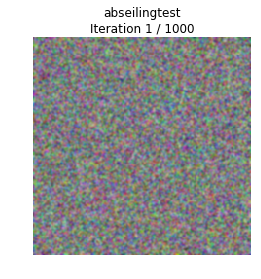

iteration: 1 1.65494012833
iteration: 2 2.26929497719
Blur time 0.1574010849
iteration: 3 3.09220004082
iteration: 4 3.71002912521
iteration: 5 4.35220313072
Blur time 0.0941829681396
iteration: 6 5.10024404526
iteration: 7 5.71524000168
iteration: 8 6.37430310249
Blur time 0.106628894806
iteration: 9 7.13641500473
iteration: 10 7.74874210358
iteration: 11 8.38811016083
Blur time 0.151237010956
iteration: 12 9.20645308495
iteration: 13 9.83431005478
iteration: 14 10.4573481083
Blur time 0.108000040054
iteration: 15 11.1811830997
iteration: 16 11.7875790596
iteration: 17 12.3987209797
Blur time 0.138584136963
iteration: 18 13.1488440037
iteration: 19 13.7782590389
iteration: 20 14.4524300098
Blur time 0.153396129608
iteration: 21 15.2504281998
iteration: 22 15.8776409626
iteration: 23 16.5401871204
Blur time 0.171402931213
iteration: 24 17.3546581268


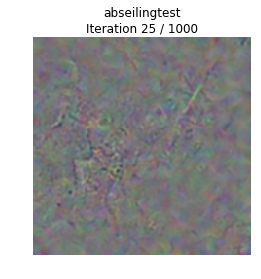

iteration: 25 18.0994460583
iteration: 26 18.7587480545
Blur time 0.158676862717
iteration: 27 19.592425108
iteration: 28 20.2185080051
iteration: 29 20.855741024
Blur time 0.16091799736
iteration: 30 21.6844961643
iteration: 31 22.3001739979
iteration: 32 22.9209520817
Blur time 0.0956220626831
iteration: 33 23.6679441929
iteration: 34 24.2798440456
iteration: 35 24.8906030655
Blur time 0.154636859894
iteration: 36 25.693500042
iteration: 37 26.3190691471
iteration: 38 26.9540171623
Blur time 0.0924100875854
iteration: 39 27.7097291946
iteration: 40 28.3165960312
iteration: 41 28.9320030212
Blur time 0.119134187698
iteration: 42 29.7116701603
iteration: 43 30.3294050694
iteration: 44 30.9990310669
Blur time 0.110208034515
iteration: 45 31.7312409878
iteration: 46 32.3654100895
iteration: 47 33.0203740597
Blur time 0.149568080902
iteration: 48 33.794396162
iteration: 49 34.4209930897


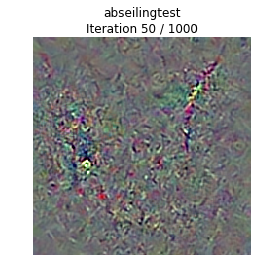

iteration: 50 35.1780850887
Blur time 0.153531074524
iteration: 51 35.9574151039
iteration: 52 36.573786974
iteration: 53 37.1839931011
Blur time 0.159873008728
iteration: 54 37.9793140888
iteration: 55 38.5992820263
iteration: 56 39.2827820778
Blur time 0.153033018112
iteration: 57 40.100028038
iteration: 58 40.7275381088
iteration: 59 41.3939881325
Blur time 0.158358812332
iteration: 60 42.2113211155
iteration: 61 42.8376550674
iteration: 62 43.5006430149
Blur time 0.121922969818
iteration: 63 44.2436811924
iteration: 64 44.8600871563
iteration: 65 45.481098175
Blur time 0.105949878693
iteration: 66 46.2546081543
iteration: 67 46.8714241982
iteration: 68 47.4944570065
Blur time 0.094997882843
iteration: 69 48.2344250679
iteration: 70 48.8418400288
iteration: 71 49.4552571774
Blur time 0.115798950195
iteration: 72 50.2225620747
iteration: 73 50.8344190121
iteration: 74 51.4479501247


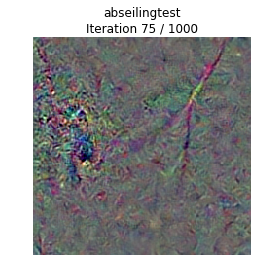

Blur time 0.154751062393
iteration: 75 52.3458471298
iteration: 76 52.9594950676
iteration: 77 53.5836751461
Blur time 0.13597202301
iteration: 78 54.5195631981
iteration: 79 55.1555900574
iteration: 80 55.8294000626
Blur time 0.0947949886322
iteration: 81 56.5873031616
iteration: 82 57.2168581486
iteration: 83 57.8904461861
Blur time 0.126554965973
iteration: 84 58.6776189804
iteration: 85 59.2991440296
iteration: 86 59.9750339985
Blur time 0.117672920227
iteration: 87 60.7654080391
iteration: 88 61.3910219669
iteration: 89 62.06062603
Blur time 0.117672204971
iteration: 90 62.8413341045
iteration: 91 63.4520881176
iteration: 92 64.0712649822
Blur time 0.158504009247
iteration: 93 64.8977999687
iteration: 94 65.5284380913
iteration: 95 66.1747860909
Blur time 0.10011100769
iteration: 96 66.9282300472
iteration: 97 67.5562400818
iteration: 98 68.2293360233
Blur time 0.155583143234
iteration: 99 69.0582180023


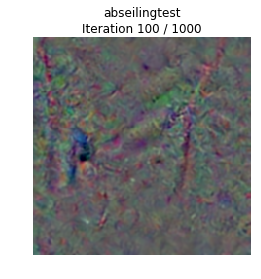

iteration: 100 69.8564040661
iteration: 101 70.4942929745
Blur time 0.155508995056
iteration: 102 71.3212270737
iteration: 103 71.9423491955
iteration: 104 72.5724551678
Blur time 0.148140192032
iteration: 105 73.3911039829
iteration: 106 74.0308589935
iteration: 107 74.7135190964
Blur time 0.150717020035
iteration: 108 75.5261571407
iteration: 109 76.1436011791
iteration: 110 76.7665200233
Blur time 0.159603834152
iteration: 111 77.5838780403
iteration: 112 78.2186419964
iteration: 113 78.8957021236
Blur time 0.133949041367
iteration: 114 79.7018699646
iteration: 115 80.3297300339
iteration: 116 80.9929499626
Blur time 0.110539913177
iteration: 117 81.7552101612
iteration: 118 82.3722240925
iteration: 119 82.9937791824
Blur time 0.14736199379
iteration: 120 83.8084709644
iteration: 121 84.4401910305
iteration: 122 85.0780220032
Blur time 0.11780500412
iteration: 123 85.8134541512
iteration: 124 86.4373700619


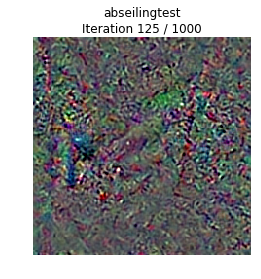

iteration: 125 87.1621360779
Blur time 0.0964469909668
iteration: 126 87.8896651268
iteration: 127 88.5114409924
iteration: 128 89.1845030785
Blur time 0.0945880413055
iteration: 129 89.8992490768
iteration: 130 90.5147190094
iteration: 131 91.1410951614
Blur time 0.094498872757
iteration: 132 91.8931651115
iteration: 133 92.5161931515
iteration: 134 93.1307179928
Blur time 0.11424612999
iteration: 135 93.8674941063
iteration: 136 94.5047180653
iteration: 137 95.1737360954
Blur time 0.15144610405
iteration: 138 95.9962711334
iteration: 139 96.6207540035
iteration: 140 97.2715489864
Blur time 0.146376848221
iteration: 141 98.0380961895
iteration: 142 98.6776130199
iteration: 143 99.3432950974
Blur time 0.149485111237
iteration: 144 100.124195099
iteration: 145 100.753606081
iteration: 146 101.428889036
Blur time 0.0961039066315
iteration: 147 102.178779125
iteration: 148 102.794506073
iteration: 149 103.435050964


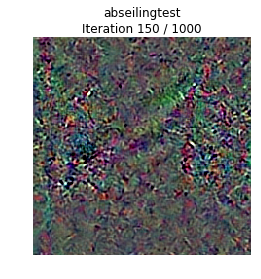

Blur time 0.0950088500977
iteration: 150 104.236416101
iteration: 151 104.858574152
iteration: 152 105.51711607
Blur time 0.151882886887
iteration: 153 106.29243803
iteration: 154 106.930728197
iteration: 155 107.601364136
Blur time 0.0946409702301
iteration: 156 108.335088968
iteration: 157 108.95273304
iteration: 158 109.604866982
Blur time 0.0957069396973
iteration: 159 110.322884083
iteration: 160 110.953970194
iteration: 161 111.625830173
Blur time 0.153032064438
iteration: 162 112.450829029
iteration: 163 113.096357107
iteration: 164 113.780479193
Blur time 0.159096956253
iteration: 165 114.625128984
iteration: 166 115.256695986
iteration: 167 115.923043966
Blur time 0.140655994415
iteration: 168 116.73913908
iteration: 169 117.374363184
iteration: 170 118.041604996
Blur time 0.147876024246
iteration: 171 118.850383997
iteration: 172 119.488022089
iteration: 173 120.170839071
Blur time 0.0960168838501
iteration: 174 120.938338041


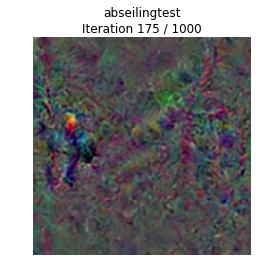

iteration: 175 121.68651104
iteration: 176 122.370896101
Blur time 0.15753698349
iteration: 177 123.215586185
iteration: 178 123.840897083
iteration: 179 124.475453138
Blur time 0.106655836105
iteration: 180 125.243489027
iteration: 181 125.861698151
iteration: 182 126.492727041
Blur time 0.14289689064
iteration: 183 127.260435104
iteration: 184 127.89778018
iteration: 185 128.522796154
Blur time 0.155732870102
iteration: 186 129.356314182
iteration: 187 129.992439032
iteration: 188 130.664188147
Blur time 0.112873077393
iteration: 189 131.453652143
iteration: 190 132.084905148
iteration: 191 132.740540981
Blur time 0.137721061707
iteration: 192 133.55441308
iteration: 193 134.186495066
iteration: 194 134.835926056
Blur time 0.0955801010132
iteration: 195 135.584516048
iteration: 196 136.208417177
iteration: 197 136.861413002
Blur time 0.152976036072
iteration: 198 137.686496973
iteration: 199 138.312796116


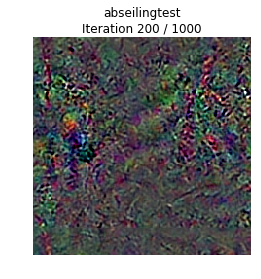

iteration: 200 139.044353008
Blur time 0.158291101456
iteration: 201 139.868236065
iteration: 202 140.500058174
iteration: 203 141.133320093
Blur time 0.122586011887
iteration: 204 141.887132168
iteration: 205 142.504868984
iteration: 206 143.157764196
Blur time 0.160796880722
iteration: 207 144.001073122
iteration: 208 144.630305052
iteration: 209 145.308034182
Blur time 0.100937128067
iteration: 210 146.083980083
iteration: 211 146.707353115
iteration: 212 147.339002132
Blur time 0.157591104507
iteration: 213 148.123692036
iteration: 214 148.766980171
iteration: 215 149.443503141
Blur time 0.111962080002
iteration: 216 150.181130171
iteration: 217 150.812091112
iteration: 218 151.47065115
Blur time 0.159830093384
iteration: 219 152.31818819
iteration: 220 152.975912094
iteration: 221 153.62334609
Blur time 0.0963950157166
iteration: 222 154.380208969
iteration: 223 154.997362137
iteration: 224 155.628628016


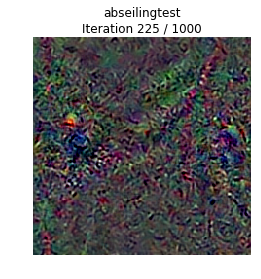

Blur time 0.146646022797
iteration: 225 156.567978144
iteration: 226 157.210137129
iteration: 227 157.888019085
Blur time 0.110752105713
iteration: 228 158.633474112
iteration: 229 159.273807049
iteration: 230 159.962795019
Blur time 0.0948839187622
iteration: 231 160.722089052
iteration: 232 161.355465174
iteration: 233 162.031810999
Blur time 0.104573011398
iteration: 234 162.809432983
iteration: 235 163.442394018
iteration: 236 164.107578039
Blur time 0.0957729816437
iteration: 237 164.869469166
iteration: 238 165.50061512
iteration: 239 166.176582098
Blur time 0.0948040485382
iteration: 240 166.939419985
iteration: 241 167.57776618
iteration: 242 168.260100126
Blur time 0.144440889359
iteration: 243 169.065756083
iteration: 244 169.711872101
iteration: 245 170.341462135
Blur time 0.0958797931671
iteration: 246 171.112048149
iteration: 247 171.735212088
iteration: 248 172.407760143
Blur time 0.155007839203
iteration: 249 173.226270199


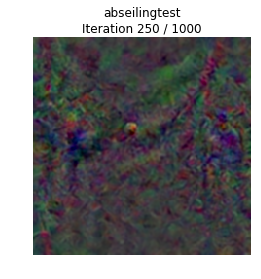

iteration: 250 173.982364178
iteration: 251 174.653213978
Blur time 0.0952460765839
iteration: 252 175.418735981
iteration: 253 176.052683115
iteration: 254 176.722547054
Blur time 0.125138044357
iteration: 255 177.521258116
iteration: 256 178.150515079
iteration: 257 178.771448135
Blur time 0.0948910713196
iteration: 258 179.511257172
iteration: 259 180.143810034
iteration: 260 180.790687084
Blur time 0.14999294281
iteration: 261 181.605655193
iteration: 262 182.28721714
iteration: 263 182.980468988
Blur time 0.0996980667114
iteration: 264 183.756499052
iteration: 265 184.383853197
iteration: 266 185.060050011
Blur time 0.15682888031
iteration: 267 185.870830059
iteration: 268 186.509418011
iteration: 269 187.166618109
Blur time 0.0946412086487
iteration: 270 187.881232977
iteration: 271 188.524337053
iteration: 272 189.204136133
Blur time 0.142952919006
iteration: 273 190.031597137
iteration: 274 190.674997091


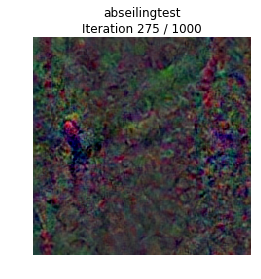

iteration: 275 191.516996145
Blur time 0.155282020569
iteration: 276 192.363262177
iteration: 277 193.002565145
iteration: 278 193.687837124
Blur time 0.0953631401062
iteration: 279 194.444718122
iteration: 280 195.070741177
iteration: 281 195.735705137
Blur time 0.128310203552
iteration: 282 196.500849009
iteration: 283 197.138898134
iteration: 284 197.829468966
Blur time 0.115483045578
iteration: 285 198.622169971
iteration: 286 199.243421078
iteration: 287 199.890305042
Blur time 0.15394115448
iteration: 288 200.725603104
iteration: 289 201.3722651
iteration: 290 202.051948071
Blur time 0.160837888718
iteration: 291 202.860488176
iteration: 292 203.497979164
iteration: 293 204.187682152
Blur time 0.119062900543
iteration: 294 204.983543158
iteration: 295 205.616541147
iteration: 296 206.30905509
Blur time 0.131608963013
iteration: 297 207.108688116
iteration: 298 207.745409966
iteration: 299 208.422082186


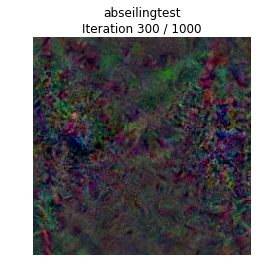

Blur time 0.0959041118622
iteration: 300 209.263780117
iteration: 301 209.881219149
iteration: 302 210.504101038
Blur time 0.118582963943
iteration: 303 211.262948036
iteration: 304 211.894179106
iteration: 305 212.546977997
Blur time 0.157917022705
iteration: 306 213.396879196
iteration: 307 214.03383112
iteration: 308 214.680925131
Blur time 0.150937080383
iteration: 309 215.520275116
iteration: 310 216.159236193
iteration: 311 216.7854352
Blur time 0.152580976486
iteration: 312 217.590908051
iteration: 313 218.241068125
iteration: 314 218.877927065
Blur time 0.152846097946
iteration: 315 219.712033033
iteration: 316 220.340085983
iteration: 317 221.001955986
Blur time 0.158566951752
iteration: 318 221.838615179
iteration: 319 222.47766304
iteration: 320 223.145529985
Blur time 0.155082941055
iteration: 321 223.993564129
iteration: 322 224.63145709
iteration: 323 225.272178173
Blur time 0.109498977661
iteration: 324 226.074223995


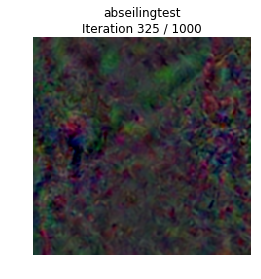

iteration: 325 226.8123312
iteration: 326 227.443179131
Blur time 0.145364999771
iteration: 327 228.244801044
iteration: 328 228.886564016
iteration: 329 229.552703142
Blur time 0.128697156906
iteration: 330 230.321349144
iteration: 331 231.023224115
iteration: 332 231.692306995
Blur time 0.158994913101
iteration: 333 232.506376982
iteration: 334 233.153455973
iteration: 335 233.844798088
Blur time 0.159733057022
iteration: 336 234.695067167
iteration: 337 235.337357044
iteration: 338 235.967887163
Blur time 0.0960340499878
iteration: 339 236.709861994
iteration: 340 237.331237078
iteration: 341 237.962526083
Blur time 0.152572154999
iteration: 342 238.801882029
iteration: 343 239.447061062
iteration: 344 240.122815132
Blur time 0.151221036911
iteration: 345 240.93661499
iteration: 346 241.579602003
iteration: 347 242.249468088
Blur time 0.15661907196
iteration: 348 243.054239988
iteration: 349 243.686470985


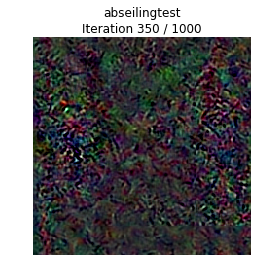

iteration: 350 244.442384005
Blur time 0.0956060886383
iteration: 351 245.159986019
iteration: 352 245.78571701
iteration: 353 246.424837112
Blur time 0.156838178635
iteration: 354 247.291543007
iteration: 355 247.935933113
iteration: 356 248.617190123
Blur time 0.162109851837
iteration: 357 249.449305058
iteration: 358 250.098460197
iteration: 359 250.755522013
Blur time 0.118900060654
iteration: 360 251.505715132
iteration: 361 252.151434183
iteration: 362 252.827538967
Blur time 0.126643896103
iteration: 363 253.643465996
iteration: 364 254.267881155
iteration: 365 254.89669013
Blur time 0.153403997421
iteration: 366 255.728883028
iteration: 367 256.359737158
iteration: 368 257.009124994
Blur time 0.0947251319885
iteration: 369 257.742487192
iteration: 370 258.379248142
iteration: 371 259.045067072
Blur time 0.152058124542
iteration: 372 259.858695984
iteration: 373 260.496370077
iteration: 374 261.12123704


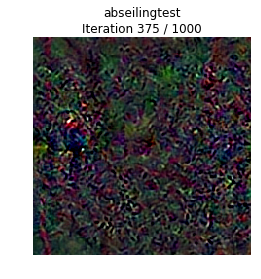

Blur time 0.156347036362
iteration: 375 262.008336067
iteration: 376 262.641545057
iteration: 377 263.302000046
Blur time 0.135401010513
iteration: 378 264.084191084
iteration: 379 264.722724199
iteration: 380 265.399554968
Blur time 0.13486790657
iteration: 381 266.228463173
iteration: 382 266.866389036
iteration: 383 267.498939991
Blur time 0.0931799411774
iteration: 384 268.221219063
iteration: 385 268.843432188
iteration: 386 269.465785027
Blur time 0.0954768657684
iteration: 387 270.187349081
iteration: 388 270.825576067
iteration: 389 271.456655025
Blur time 0.0947299003601
iteration: 390 272.177494049
iteration: 391 272.811534166
iteration: 392 273.471326113
Blur time 0.129391908646
iteration: 393 274.28519702
iteration: 394 274.926937103
iteration: 395 275.623289108
Blur time 0.158020019531
iteration: 396 276.467396021
iteration: 397 277.097700119
iteration: 398 277.735439062
Blur time 0.145746946335
iteration: 399 278.573641062


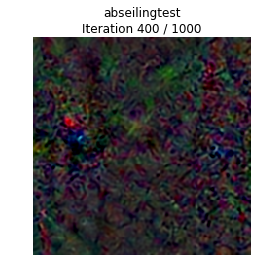

iteration: 400 279.330581188
iteration: 401 280.012788057
Blur time 0.153768062592
iteration: 402 280.810366154
iteration: 403 281.456816196
iteration: 404 282.132275105
Blur time 0.0993077754974
iteration: 405 282.86268115
iteration: 406 283.490578175
iteration: 407 284.121860027
Blur time 0.148754835129
iteration: 408 284.963025093
iteration: 409 285.604992151
iteration: 410 286.263576984
Blur time 0.0949010848999
iteration: 411 286.991379976
iteration: 412 287.628120184
iteration: 413 288.283104181
Blur time 0.0951700210571
iteration: 414 289.033657074
iteration: 415 289.674357176
iteration: 416 290.367063046
Blur time 0.154205083847
iteration: 417 291.216959
iteration: 418 291.869126081
iteration: 419 292.550165176
Blur time 0.100201845169
iteration: 420 293.324939966
iteration: 421 293.961464167
iteration: 422 294.646150112
Blur time 0.0953669548035
iteration: 423 295.423031092
iteration: 424 296.065935135


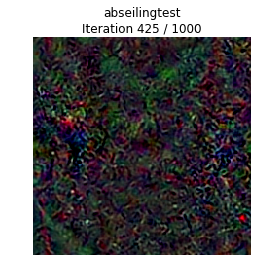

iteration: 425 296.871268034
Blur time 0.159842967987
iteration: 426 297.670097113
iteration: 427 298.321096182
iteration: 428 299.019128084
Blur time 0.119530916214
iteration: 429 299.813918114
iteration: 430 300.457123995
iteration: 431 301.123978138
Blur time 0.115594148636
iteration: 432 301.91485405
iteration: 433 302.549501181
iteration: 434 303.187364101
Blur time 0.115727901459
iteration: 435 303.986227036
iteration: 436 304.623703003
iteration: 437 305.310431004
Blur time 0.13459277153
iteration: 438 306.087027073
iteration: 439 306.774192095
iteration: 440 307.456618071
Blur time 0.152583837509
iteration: 441 308.244807005
iteration: 442 308.901736975
iteration: 443 309.605592012
Blur time 0.157477140427
iteration: 444 310.453845024
iteration: 445 311.106012106
iteration: 446 311.817593098
Blur time 0.158579826355
iteration: 447 312.651673079
iteration: 448 313.299345016
iteration: 449 313.974267006


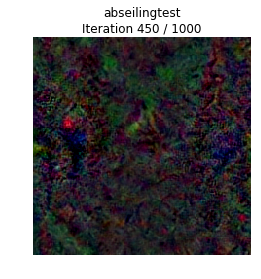

Blur time 0.154224872589
iteration: 450 314.892548084
iteration: 451 315.535254002
iteration: 452 316.192795992
Blur time 0.150568962097
iteration: 453 316.978747129
iteration: 454 317.629268169
iteration: 455 318.326729059
Blur time 0.100042104721
iteration: 456 319.12025404
iteration: 457 319.772696972
iteration: 458 320.471117973
Blur time 0.15740609169
iteration: 459 321.323585987
iteration: 460 321.977190018
iteration: 461 322.66606307
Blur time 0.162984132767
iteration: 462 323.525647163
iteration: 463 324.170122147
iteration: 464 324.86756897
Blur time 0.151293992996
iteration: 465 325.720607996
iteration: 466 326.375676155
iteration: 467 327.059897184
Blur time 0.162569999695
iteration: 468 327.914352179
iteration: 469 328.562489033
iteration: 470 329.214748144
Blur time 0.0990149974823
iteration: 471 330.002503157
iteration: 472 330.633962154
iteration: 473 331.270429134
Blur time 0.109083890915
iteration: 474 332.054927111


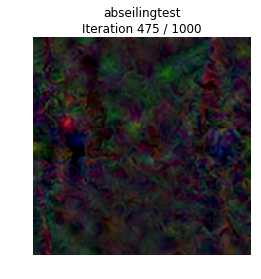

iteration: 475 332.81045413
iteration: 476 333.48418498
Blur time 0.154252052307
iteration: 477 334.33654213
iteration: 478 334.984490156
iteration: 479 335.66763401
Blur time 0.150845050812
iteration: 480 336.460500002
iteration: 481 337.107257128
iteration: 482 337.746003151
Blur time 0.101433038712
iteration: 483 338.481914043
iteration: 484 339.123562098
iteration: 485 339.806801081
Blur time 0.163913011551
iteration: 486 340.673129082
iteration: 487 341.319730997
iteration: 488 341.981630087
Blur time 0.155297994614
iteration: 489 342.778844118
iteration: 490 343.441121101
iteration: 491 344.140374184
Blur time 0.14125084877
iteration: 492 344.976459026
iteration: 493 345.62097311
iteration: 494 346.284054041
Blur time 0.15668797493
iteration: 495 347.121957064
iteration: 496 347.771483183
iteration: 497 348.458873034
Blur time 0.141630887985
iteration: 498 349.248414993
iteration: 499 349.884060144


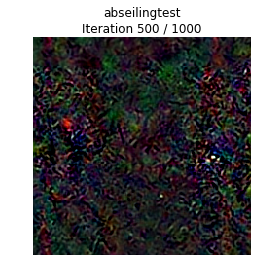

iteration: 500 350.614988089
Blur time 0.0981020927429
iteration: 501 351.346292973
iteration: 502 351.996661186
iteration: 503 352.856580973
Blur time 0.0989530086517
iteration: 504 353.593809128
iteration: 505 354.24121213
iteration: 506 354.937887192
Blur time 0.0981779098511
iteration: 507 355.671300173
iteration: 508 356.31351614
iteration: 509 356.97846508
Blur time 0.0982789993286
iteration: 510 357.716550112
iteration: 511 358.358731985
iteration: 512 358.991566181
Blur time 0.092698097229
iteration: 513 359.712406158
iteration: 514 360.343696117
iteration: 515 360.988731146
Blur time 0.0983259677887
iteration: 516 361.789319992
iteration: 517 362.437359095
iteration: 518 363.130406141
Blur time 0.156569004059
iteration: 519 363.929270029
iteration: 520 364.572213173
iteration: 521 365.218214989
Blur time 0.100224018097
iteration: 522 366.01547718
iteration: 523 366.658568144
iteration: 524 367.309628963


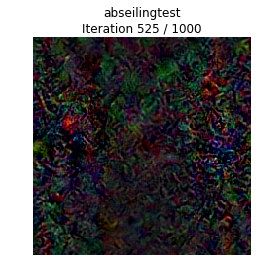

Blur time 0.146435022354
iteration: 525 368.27927804
iteration: 526 368.943881035
iteration: 527 369.633064985
Blur time 0.14057803154
iteration: 528 370.465945005
iteration: 529 371.117676973
iteration: 530 371.789015055
Blur time 0.154567956924
iteration: 531 372.624214172
iteration: 532 373.287120104
iteration: 533 373.985942125
Blur time 0.151448011398
iteration: 534 374.826093197
iteration: 535 375.488353014
iteration: 536 376.194281101
Blur time 0.136640071869
iteration: 537 376.984166145
iteration: 538 377.627643108
iteration: 539 378.271793127
Blur time 0.151551008224
iteration: 540 379.110418081
iteration: 541 379.766491175
iteration: 542 380.473946095
Blur time 0.120180130005
iteration: 543 381.281208992
iteration: 544 381.922785044
iteration: 545 382.571689129
Blur time 0.102551937103
iteration: 546 383.366237164
iteration: 547 384.015017986
iteration: 548 384.667016983
Blur time 0.134748935699
iteration: 549 385.452090025


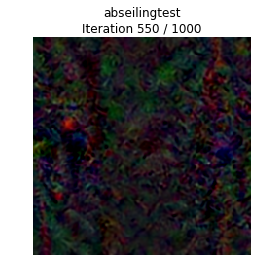

iteration: 550 386.211894035
iteration: 551 386.917114019
Blur time 0.150913953781
iteration: 552 387.772543192
iteration: 553 388.494835138
iteration: 554 389.193386078
Blur time 0.118268013
iteration: 555 389.959020138
iteration: 556 390.603406191
iteration: 557 391.276254177
Blur time 0.104842185974
iteration: 558 392.087316036
iteration: 559 392.736347198
iteration: 560 393.430457115
Blur time 0.0986390113831
iteration: 561 394.228731155
iteration: 562 394.880558014
iteration: 563 395.558861017
Blur time 0.127810955048
iteration: 564 396.388269186
iteration: 565 397.040909052
iteration: 566 397.742379189
Blur time 0.117186784744
iteration: 567 398.546813965
iteration: 568 399.207911015
iteration: 569 399.920675993
Blur time 0.154701948166
iteration: 570 400.788181067
iteration: 571 401.447409153
iteration: 572 402.19885397
Blur time 0.122295856476
iteration: 573 402.993584156
iteration: 574 403.637936115


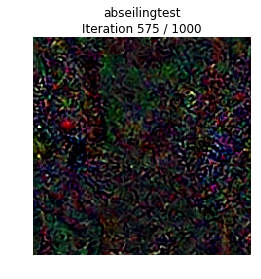

iteration: 575 404.378025055
Blur time 0.0929958820343
iteration: 576 405.111198187
iteration: 577 405.746489048
iteration: 578 406.390516043
Blur time 0.0975148677826
iteration: 579 407.154558182
iteration: 580 407.809018135
iteration: 581 408.506294966
Blur time 0.0976920127869
iteration: 582 409.256458998
iteration: 583 409.903463125
iteration: 584 410.580437183
Blur time 0.159040927887
iteration: 585 411.445263147
iteration: 586 412.102190018
iteration: 587 412.762516975
Blur time 0.155803918839
iteration: 588 413.583445072
iteration: 589 414.231048107
iteration: 590 414.885838032
Blur time 0.115754842758
iteration: 591 415.707715034
iteration: 592 416.347095013
iteration: 593 416.996567965
Blur time 0.118031978607
iteration: 594 417.815620184
iteration: 595 418.459241152
iteration: 596 419.146237135
Blur time 0.12998509407
iteration: 597 419.977248192
iteration: 598 420.626996994
iteration: 599 421.298226118


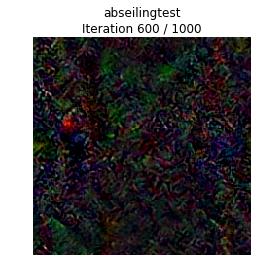

Blur time 0.152805089951
iteration: 600 422.194051981
iteration: 601 422.853550196
iteration: 602 423.543794155
Blur time 0.152216911316
iteration: 603 424.375030041
iteration: 604 425.056300163
iteration: 605 425.753373146
Blur time 0.150738954544
iteration: 606 426.553261042
iteration: 607 427.21432209
iteration: 608 427.907566071
Blur time 0.100139856339
iteration: 609 428.657473087
iteration: 610 429.317111969
iteration: 611 430.023910046
Blur time 0.159719944
iteration: 612 430.844500065
iteration: 613 431.50218606
iteration: 614 432.195078135
Blur time 0.16169500351
iteration: 615 433.008870125
iteration: 616 433.660466194
iteration: 617 434.308025122
Blur time 0.0995149612427
iteration: 618 435.059084177
iteration: 619 435.718111038
iteration: 620 436.419188023
Blur time 0.11640381813
iteration: 621 437.200530052
iteration: 622 437.856279135
iteration: 623 438.571082115
Blur time 0.148619890213
iteration: 624 439.430670023


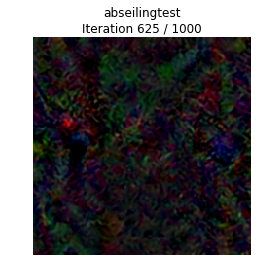

iteration: 625 440.20917511
iteration: 626 440.90213418
Blur time 0.153362035751
iteration: 627 441.756016016
iteration: 628 442.403757095
iteration: 629 443.048766136
Blur time 0.159987926483
iteration: 630 443.876605034
iteration: 631 444.539252043
iteration: 632 445.23114419
Blur time 0.114675045013
iteration: 633 446.010075092
iteration: 634 446.663594007
iteration: 635 447.311249018
Blur time 0.131895065308
iteration: 636 448.091428041
iteration: 637 448.743834972
iteration: 638 449.401818991
Blur time 0.112253904343
iteration: 639 450.218877077
iteration: 640 450.868259192
iteration: 641 451.544500113
Blur time 0.13131403923
iteration: 642 452.384315014
iteration: 643 453.042890072
iteration: 644 453.753561974
Blur time 0.173614025116
iteration: 645 454.638792992
iteration: 646 455.289899111
iteration: 647 455.935022116
Blur time 0.0934998989105
iteration: 648 456.676671028
iteration: 649 457.325829029


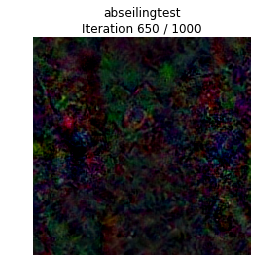

iteration: 650 458.184039116
Blur time 0.156186819077
iteration: 651 459.04226017
iteration: 652 459.70037818
iteration: 653 460.400366068
Blur time 0.161179065704
iteration: 654 461.279309988
iteration: 655 461.952903986
iteration: 656 462.672275066
Blur time 0.133444786072
iteration: 657 463.507076979
iteration: 658 464.162744045
iteration: 659 464.849910975
Blur time 0.141623973846
iteration: 660 465.634557009
iteration: 661 466.334946156
iteration: 662 467.046710968
Blur time 0.11923789978
iteration: 663 467.87019515
iteration: 664 468.516798019
iteration: 665 469.172363043
Blur time 0.11624789238
iteration: 666 469.987307072
iteration: 667 470.649055004
iteration: 668 471.354196072
Blur time 0.155323982239
iteration: 669 472.187909126
iteration: 670 472.86305213
iteration: 671 473.575085163
Blur time 0.153906106949
iteration: 672 474.431035042
iteration: 673 475.09128499
iteration: 674 475.776826143


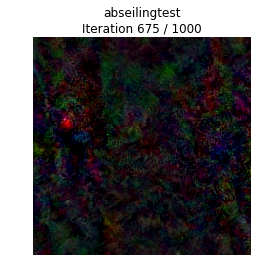

Blur time 0.15430688858
iteration: 675 476.74151206
iteration: 676 477.414340019
iteration: 677 478.116089106
Blur time 0.123288869858
iteration: 678 478.890993118
iteration: 679 479.548288107
iteration: 680 480.247745991
Blur time 0.139004945755
iteration: 681 481.08636713
iteration: 682 481.743426085
iteration: 683 482.452785015
Blur time 0.10880112648
iteration: 684 483.225242138
iteration: 685 483.875313997
iteration: 686 484.57199502
Blur time 0.158353090286
iteration: 687 485.396301031
iteration: 688 486.065858126
iteration: 689 486.772463083
Blur time 0.160653114319
iteration: 690 487.649530172
iteration: 691 488.314721107
iteration: 692 488.959208965
Blur time 0.128736019135
iteration: 693 489.740125179
iteration: 694 490.401475191
iteration: 695 491.111517191
Blur time 0.116793870926
iteration: 696 491.91575408
iteration: 697 492.580322981
iteration: 698 493.290426016
Blur time 0.104425907135
iteration: 699 494.086369991


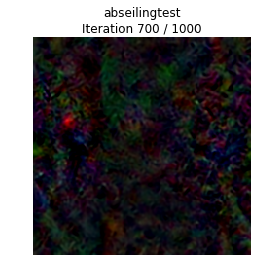

iteration: 700 494.857865095
iteration: 701 495.532895088
Blur time 0.154335021973
iteration: 702 496.41023612
iteration: 703 497.081052065
iteration: 704 497.791624069
Blur time 0.131366968155
iteration: 705 498.64154315
iteration: 706 499.299201012
iteration: 707 499.950255156
Blur time 0.0954608917236
iteration: 708 500.698371172
iteration: 709 501.346742153
iteration: 710 502.062323093
Blur time 0.15543794632
iteration: 711 502.920785189
iteration: 712 503.581748962
iteration: 713 504.237241983
Blur time 0.138781070709
iteration: 714 505.042527199
iteration: 715 505.707036018
iteration: 716 506.415034056
Blur time 0.14327788353
iteration: 717 507.252336025
iteration: 718 507.921579123
iteration: 719 508.636911154
Blur time 0.160158872604
iteration: 720 509.504415989
iteration: 721 510.170013189
iteration: 722 510.840056181
Blur time 0.121322870255
iteration: 723 511.608314991
iteration: 724 512.278584003


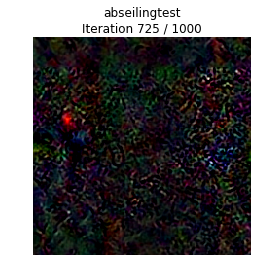

iteration: 725 513.173655033
Blur time 0.0973908901215
iteration: 726 513.985646963
iteration: 727 514.646799088
iteration: 728 515.358610153
Blur time 0.153361082077
iteration: 729 516.230799198
iteration: 730 516.90190506
iteration: 731 517.609240055
Blur time 0.158382892609
iteration: 732 518.441210032
iteration: 733 519.106219053
iteration: 734 519.812887192
Blur time 0.111531972885
iteration: 735 520.647442102
iteration: 736 521.31051898
iteration: 737 522.005316019
Blur time 0.152698040009
iteration: 738 522.821712971
iteration: 739 523.483357191
iteration: 740 524.279528141
Blur time 0.155470132828
iteration: 741 525.130108118
iteration: 742 525.798778057
iteration: 743 526.48508811
Blur time 0.116103887558
iteration: 744 527.300707102
iteration: 745 527.958235025
iteration: 746 528.613874197
Blur time 0.110251903534
iteration: 747 529.408936977
iteration: 748 530.075293064
iteration: 749 530.791128159


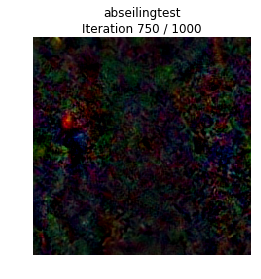

Blur time 0.153642892838
iteration: 750 531.780184984
iteration: 751 532.450909138
iteration: 752 533.146190166
Blur time 0.154422044754
iteration: 753 534.004266977
iteration: 754 534.669388056
iteration: 755 535.3853302
Blur time 0.0989499092102
iteration: 756 536.191761017
iteration: 757 536.848236084
iteration: 758 537.509214163
Blur time 0.140582084656
iteration: 759 538.315009117
iteration: 760 538.981635094
iteration: 761 539.693935156
Blur time 0.0980229377747
iteration: 762 540.464352131
iteration: 763 541.127717018
iteration: 764 541.820724964
Blur time 0.144292831421
iteration: 765 542.633330107
iteration: 766 543.292073965
iteration: 767 543.979199171
Blur time 0.161653995514
iteration: 768 544.861107111
iteration: 769 545.527446032
iteration: 770 546.230417013
Blur time 0.0978691577911
iteration: 771 546.993360996
iteration: 772 547.6582582
iteration: 773 548.377549171
Blur time 0.173191070557
iteration: 774 549.267999172


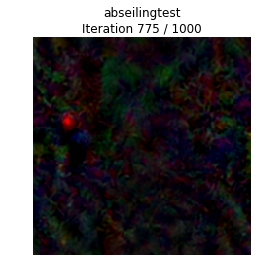

iteration: 775 550.05819416
iteration: 776 550.773853064
Blur time 0.150681018829
iteration: 777 551.632878065
iteration: 778 552.299147129
iteration: 779 552.989773989
Blur time 0.153021097183
iteration: 780 553.861701012
iteration: 781 554.535152197
iteration: 782 555.254413128
Blur time 0.153693199158
iteration: 783 556.139496088
iteration: 784 556.811944008
iteration: 785 557.530219078
Blur time 0.16122508049
iteration: 786 558.353317022
iteration: 787 559.019627094
iteration: 788 559.705075026
Blur time 0.166298866272
iteration: 789 560.584598064
iteration: 790 561.252082109
iteration: 791 561.953233004
Blur time 0.169611930847
iteration: 792 562.848791122
iteration: 793 563.515891075
iteration: 794 564.232561111
Blur time 0.0983059406281
iteration: 795 565.022313118
iteration: 796 565.685126066
iteration: 797 566.396888971
Blur time 0.112732887268
iteration: 798 567.226822138
iteration: 799 567.88501811


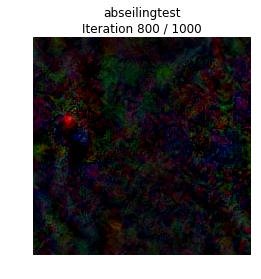

iteration: 800 568.645214081
Blur time 0.145447015762
iteration: 801 569.456629038
iteration: 802 570.125669003
iteration: 803 570.831843138
Blur time 0.102910041809
iteration: 804 571.613717079
iteration: 805 572.273736
iteration: 806 572.960036993
Blur time 0.150898933411
iteration: 807 573.773200989
iteration: 808 574.434092045
iteration: 809 575.092162132
Blur time 0.11923789978
iteration: 810 575.869518995
iteration: 811 576.534912109
iteration: 812 577.225054026
Blur time 0.0967719554901
iteration: 813 578.016471148
iteration: 814 578.676432133
iteration: 815 579.342629194
Blur time 0.099582195282
iteration: 816 580.149389982
iteration: 817 580.803915024
iteration: 818 581.473801136
Blur time 0.0999112129211
iteration: 819 582.234622002
iteration: 820 582.917651176
iteration: 821 583.637665033
Blur time 0.142729997635
iteration: 822 584.492529154
iteration: 823 585.144968987
iteration: 824 585.80777216


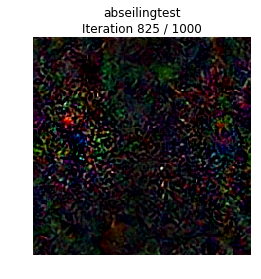

Blur time 0.150454998016
iteration: 825 586.806643963
iteration: 826 587.477329016
iteration: 827 588.180464983
Blur time 0.159027099609
iteration: 828 589.069756031
iteration: 829 589.732426167
iteration: 830 590.440067053
Blur time 0.168364048004
iteration: 831 591.34416604
iteration: 832 592.012042999
iteration: 833 592.728901148
Blur time 0.101227998734
iteration: 834 593.496715069
iteration: 835 594.158961058
iteration: 836 594.834419966
Blur time 0.0987961292267
iteration: 837 595.634052992
iteration: 838 596.289657116
iteration: 839 596.952490091
Blur time 0.161296129227
iteration: 840 597.831066132
iteration: 841 598.503763199
iteration: 842 599.2063241
Blur time 0.0982718467712
iteration: 843 599.990225077
iteration: 844 600.650135994
iteration: 845 601.351186037
Blur time 0.0977981090546
iteration: 846 602.161040068
iteration: 847 602.837726116
iteration: 848 603.563441992
Blur time 0.154917001724
iteration: 849 604.438928127


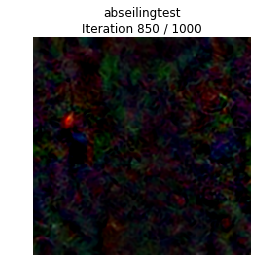

iteration: 850 605.220000982
iteration: 851 605.950291157
Blur time 0.159414052963
iteration: 852 606.863875151
iteration: 853 607.542114019
iteration: 854 608.264360189
Blur time 0.152751207352
iteration: 855 609.109053135
iteration: 856 609.782114983
iteration: 857 610.493965149
Blur time 0.186514139175
iteration: 858 611.35358119
iteration: 859 612.03831315
iteration: 860 612.752072096
Blur time 0.0976271629333
iteration: 861 613.502505064
iteration: 862 614.163985014
iteration: 863 614.824774981
Blur time 0.131468057632
iteration: 864 615.622130156
iteration: 865 616.297188044
iteration: 866 617.027357101
Blur time 0.0984950065613
iteration: 867 617.827548027
iteration: 868 618.485668182
iteration: 869 619.142802
Blur time 0.10274887085
iteration: 870 619.912893057
iteration: 871 620.582515001
iteration: 872 621.300668001
Blur time 0.160245895386
iteration: 873 622.136953115
iteration: 874 622.813085079


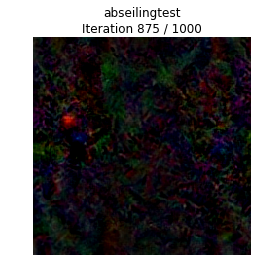

iteration: 875 623.623857975
Blur time 0.162168979645
iteration: 876 624.468443155
iteration: 877 625.141638041
iteration: 878 625.854057074
Blur time 0.152867078781
iteration: 879 626.686174154
iteration: 880 627.360505104
iteration: 881 628.056596994
Blur time 0.156971931458
iteration: 882 628.898761034
iteration: 883 629.569166183
iteration: 884 630.283692122
Blur time 0.117929935455
iteration: 885 631.068048
iteration: 886 631.740925074
iteration: 887 632.465007067
Blur time 0.097748041153
iteration: 888 633.230764151
iteration: 889 633.888507128
iteration: 890 634.562120199
Blur time 0.166857004166
iteration: 891 635.463551998
iteration: 892 636.1920681
iteration: 893 636.897192001
Blur time 0.155101060867
iteration: 894 637.738950014
iteration: 895 638.477207184
iteration: 896 639.224110126
Blur time 0.147617101669
iteration: 897 640.075244188
iteration: 898 640.749503136
iteration: 899 641.472037077


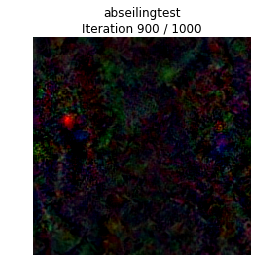

Blur time 0.160006046295
iteration: 900 642.423879147
iteration: 901 643.098358154
iteration: 902 643.766968966
Blur time 0.156852006912
iteration: 903 644.624053001
iteration: 904 645.301786184
iteration: 905 646.02136302
Blur time 0.0990500450134
iteration: 906 646.801139116
iteration: 907 647.466863155
iteration: 908 648.179787159
Blur time 0.152666091919
iteration: 909 649.008920193
iteration: 910 649.691002131
iteration: 911 650.411364079
Blur time 0.152292013168
iteration: 912 651.236819983
iteration: 913 651.90835309
iteration: 914 652.62789607
Blur time 0.135229110718
iteration: 915 653.42592907
iteration: 916 654.091577053
iteration: 917 654.753545046
Blur time 0.12832903862
iteration: 918 655.551776171
iteration: 919 656.240168095
iteration: 920 656.959587097
Blur time 0.154903173447
iteration: 921 657.7957201
iteration: 922 658.459246159
iteration: 923 659.12195015
Blur time 0.0981941223145
iteration: 924 659.887444019


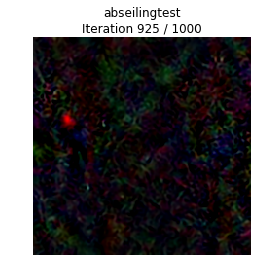

iteration: 925 660.668622971
iteration: 926 661.404064178
Blur time 0.118628025055
iteration: 927 662.240556002
iteration: 928 662.924210072
iteration: 929 663.628048182
Blur time 0.1270570755
iteration: 930 664.482537031
iteration: 931 665.160345078
iteration: 932 665.898768187
Blur time 0.157531023026
iteration: 933 666.786506176
iteration: 934 667.461179018
iteration: 935 668.141057968
Blur time 0.110557079315
iteration: 936 668.920134068
iteration: 937 669.591538191
iteration: 938 670.309616089
Blur time 0.16046500206
iteration: 939 671.187180996
iteration: 940 671.873558044
iteration: 941 672.604905128
Blur time 0.155471086502
iteration: 942 673.513064146
iteration: 943 674.188538074
iteration: 944 674.85209918
Blur time 0.0975389480591
iteration: 945 675.612832069
iteration: 946 676.288006067
iteration: 947 677.010028124
Blur time 0.128417015076
iteration: 948 677.807764053
iteration: 949 678.487912178


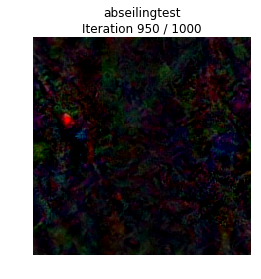

iteration: 950 679.396136999
Blur time 0.108393192291
iteration: 951 680.186700106
iteration: 952 680.853736162
iteration: 953 681.531028986
Blur time 0.115897893906
iteration: 954 682.309401035
iteration: 955 682.987418175
iteration: 956 683.724646091
Blur time 0.143847942352
iteration: 957 684.59809804
iteration: 958 685.270754099
iteration: 959 685.943181038
Blur time 0.152716159821
iteration: 960 686.801876068
iteration: 961 687.470431089
iteration: 962 688.144566059
Blur time 0.146549940109
iteration: 963 689.023372173
iteration: 964 689.696540117
iteration: 965 690.428181171
Blur time 0.156411886215
iteration: 966 691.301795006
iteration: 967 691.988304138
iteration: 968 692.717149973
Blur time 0.156122922897
iteration: 969 693.604304075
iteration: 970 694.279536009
iteration: 971 694.994938135
Blur time 0.0978758335114
iteration: 972 695.791373014
iteration: 973 696.466618061
iteration: 974 697.206325054


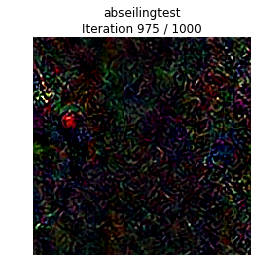

Blur time 0.0979731082916
iteration: 975 698.144515038
iteration: 976 698.818754196
iteration: 977 699.52895999
Blur time 0.163070201874
iteration: 978 700.438369036
iteration: 979 701.113278151
iteration: 980 701.789373159
Blur time 0.0989079475403
iteration: 981 702.612198114
iteration: 982 703.276381016
iteration: 983 703.95554018
Blur time 0.148285150528
iteration: 984 704.782448053
iteration: 985 705.453987122
iteration: 986 706.126588106
Blur time 0.152493953705
iteration: 987 706.982995987
iteration: 988 707.659226179
iteration: 989 708.380887032
Blur time 0.0983870029449
iteration: 990 709.141614199
iteration: 991 709.807280064
iteration: 992 710.485839128
Blur time 0.107424020767
iteration: 993 711.324537992
iteration: 994 712.007107019
iteration: 995 712.737043142
Blur time 0.127418041229
iteration: 996 713.585447073
iteration: 997 714.259796143
iteration: 998 714.967769146
Blur time 0.155256032944
iteration: 999 715.858999014
[[[ 1.84649273e-01  1.47727640e-01  1.05804920e-0

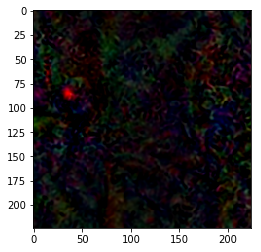

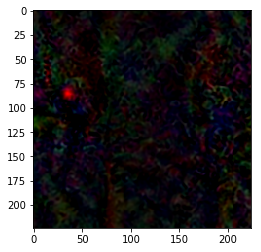

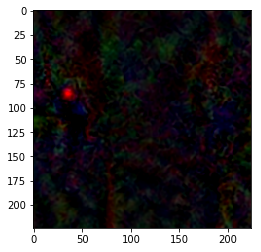

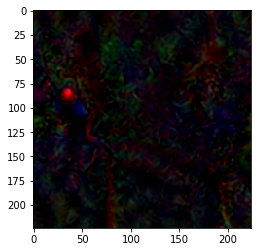

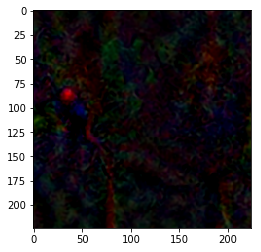

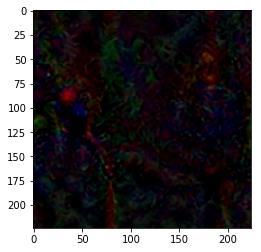

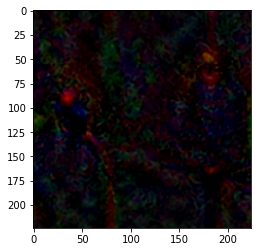

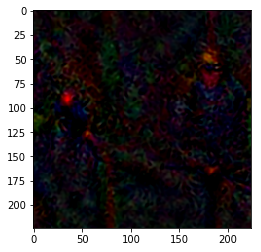

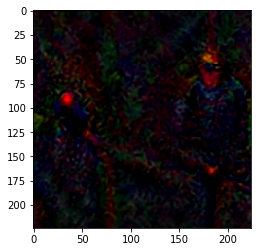

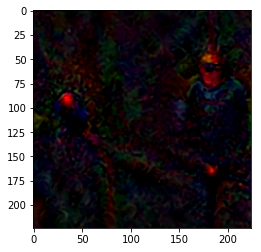

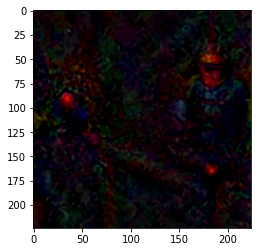

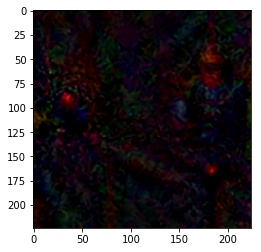

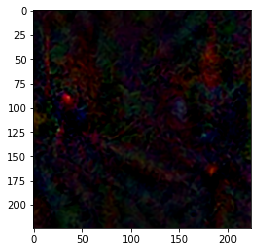

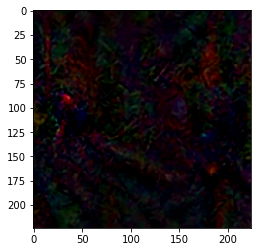

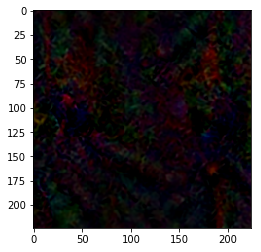

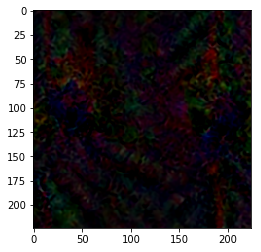

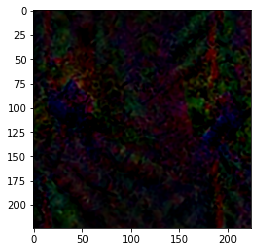

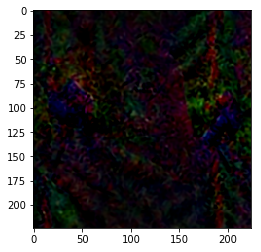

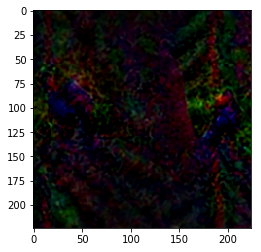

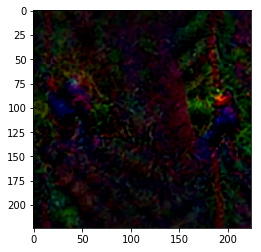

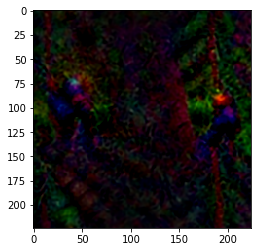

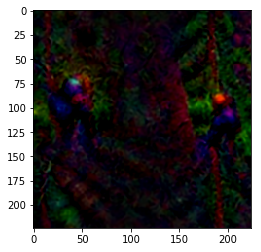

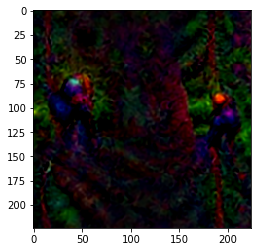

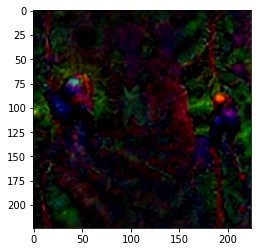

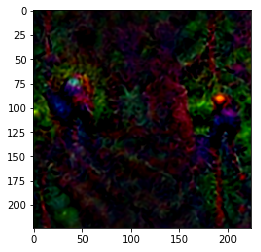

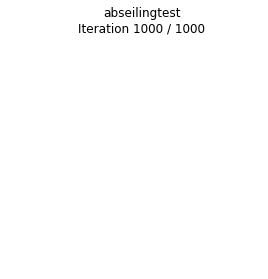

In [9]:
import imageio
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
print(model_logits)
print(rgb_input)
target = 0
print(kinetics_classes[target])
action_name = kinetics_classes[target].replace(" ", "_")
with tf.device("/gpu:0"):
    with tf.Session() as sess:
        # THIS LINE NEEDS TO BE MOVED
        rgb_saver.restore(sess, _CHECKPOINT_PATHS['rgb_imagenet'])
        create_class_visualization(sess, target, model_logits, rgb_input, action_name + "test", num_frames=25, num_iterations=1000, learning_rate=1.5, blur_every=3, max_jitter=32)

In [ ]:
def create_visual_flow(X):
        return np.append(X + 0.5, 0.5 * np.ones((224, 224, 1)), axis=2)

def create_class_visualization_flow(sess, target_y, logits, flow_input, class_name, **kwargs):
    """
    Generate an image to maximize the score of target_y under a pretrained model.
    
    Inputs:
    - target_y: Integer in the range [0, 1000) giving the index of the class
    - model: A pretrained CNN that will be used to generate the image
    
    Keyword arguments:
    - l2_reg: Strength of L2 regularization on the image
    - learning_rate: How big of a step to take
    - num_iterations: How many iterations to use
    - blur_every: How often to blur the image as an implicit regularizer
    - max_jitter: How much to gjitter the image as an implicit regularizer
    - show_every: How often to show the intermediate result
    """
    print("params", kwargs)
    l2_reg = kwargs.pop('l2_reg', 1e-3)
    learning_rate = kwargs.pop('learning_rate', 25)
    num_iterations = kwargs.pop('num_iterations', 100)
    blur_every = kwargs.pop('blur_every', 4)
    max_jitter = kwargs.pop('max_jitter', 16)
    show_every = kwargs.pop('show_every', 25)
    num_frames = kwargs.pop('num_frames', 25)
    

    X = np.random.rand(1, 224, 224, 2)
    # preprocess as described in paper
    X = X - .5
    X = X[None]
    #X = preprocess_image(X)[None]
    
    ########################################################################
    # TODO: Compute the loss and the gradient of the loss with respect to  #
    # the input image, model.image. We compute these outside the loop so   #
    # that we don't have to recompute the gradient graph at each iteration #
    #                                                                      #
    # Note: loss and grad should be TensorFlow Tensors, not numpy arrays!  #
    #                                                                      #
    # The loss is the score for the target label, target_y. You should     #
    # use model.classifier to get the scores, and tf.gradients to compute  #
    # gradients. Don't forget the (subtracted) L2 regularization term!     #
    ########################################################################
    # logits command
    # loss = model.classifier[0, target_y] # scalar loss
    loss = logits[0, target_y] # scalar loss
    
    # model.image is just input data 
    # self.image = tf.placeholder('float',shape=[None,None,None,3],name='input_image')
    # grad = tf.gradients(loss, model.image) # gradient of loss with respect to model.image, same size as model.image
    # grad = tf.squeeze(grad) - l2_reg*2*model.image
    
    grad = tf.gradients(loss, rgb_input)
    grad = tf.squeeze(grad) - l2_reg*2*rgb_input
    ############################################################################
    #                             END OF YOUR CODE                             #
    ############################################################################

    start_time = time.time()
    for t in range(num_iterations):
        
        # Randomly jitter the image a bit; this gives slightly nicer results
        ox, oy = np.random.randint(-max_jitter, max_jitter+1, 2)
        Xi = X.copy()
        X = np.roll(np.roll(X, ox, 1), oy, 2)

        ########################################################################
        # TODO: Use sess to compute the value of the gradient of the score for #
        # class target_y with respect to the pixels of the image, and make a   #
        # gradient step on the image using the learning rate. You should use   #
        # the grad variable you defined above.                                 #
        #                                                                      #
        # Be very careful about the signs of elements in your code.            #
        ########################################################################
        # we want logits for loss, model.classifier are just logits
        # loss = model.classifier[0, target_y] # scalar loss
        loss = logits[0, target_y] # scalar loss

        # model.image is just the data matrix input (a gif in our case)
        # gradient_step = sess.run(grad, feed_dict={model.image:X})
        gradient_step = sess.run(grad, feed_dict={rgb_input:X})
        X += learning_rate * gradient_step
        ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################

        # Undo the jitter
        X = np.roll(np.roll(X, -ox, 1), -oy, 2)

        # As a regularizer, clip and periodically blur
        #X = np.clip(X, -SQUEEZENET_MEAN/SQUEEZENET_STD, (1.0 - SQUEEZENET_MEAN)/SQUEEZENET_STD)
        if t % blur_every == 0:
            X = blur_image(X, sigma=1)
        print("iteration:", t, time.time()-start_time)
        # Periodically show the image
        if t == 0 or (t + 1) % show_every == 0 or t == num_iterations - 1:
            #plt.imshow(deprocess_image(X[0]))
            
            plt.imshow(create_visual_flow(X[0][0]))
            
            if t == num_iterations-1:
                # save all frames
                directory = "experiments_flow/{}_flow".format(class_name)
                if not os.path.exists(directory):
                    os.makedirs(directory)
                file_name = directory + "/{}_flow".format(class_name)+ "{}.png"
                print("file_name", file_name)
                filenames = []
                for i in range(0, num_frames):
                    plt.imshow(create_visual_flow(X[0][i]))
                    filename = file_name.format(i)
                    filenames.append(filename)
                    plt.savefig(filename.format(i))
                    #plt.show()
                #create gif
                images = []
                for filename in filenames:
                    images.append(imageio.imread(filename))
                    imageio.mimsave(directory + "/{}".format(class_name) + ".gif", images)
                    
            plt.title('%s\nIteration %d / %d' % (class_name, t + 1, num_iterations))
            plt.gcf().set_size_inches(4, 4)
            plt.axis('off')
            plt.show()
        
    return X

In [ ]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
print(model_logits)
print(rgb_input)
target = 0
print(kinetics_classes[target])
action_name = kinetics_classes[target].replace(" ", "_")
with tf.device("/gpu:0"):
    with tf.Session() as sess:
        # THIS LINE NEEDS TO BE MOVED
        flow_saver.restore(sess, _CHECKPOINT_PATHS['flow_imagenet'])
        create_class_visualization(sess, target, model_logits, rgb_input, action_name + "test", num_frames=25, num_iterations=1000, learning_rate=1.5, blur_every=3, max_jitter=32)